### Practica 14-1 Arbol de clasificación con poda

Condiciones de parada durante el entrenamiento (poda a priori):

max_depth=10: Restringe la profundidad máxima del árbol a 10 niveles.
min_samples_split=5: Un nodo solo se dividirá si contiene al menos 5 muestras.

El criterio de poda a posteriori se basa en minimizar el error de validación mientras se penaliza la complejidad del árbol.

La idea detrás de la poda de árboles es encontrar un equilibrio entre precisión en el conjunto de entrenamiento y capacidad de generalización en el conjunto de prueba.

El árbol final depende de un balance entre el error de entrenamiento y el de validación, y se selecciona el árbol que mejor generaliza.

En la poda a posteriori, el proceso implica un compromiso entre la complejidad del modelo (número de nodos y ramas) y su capacidad de generalización. Este compromiso se evalúa al medir el rendimiento del árbol podado en un conjunto de validación, lo cual es esencial para determinar el mejor árbol final.

En la poda a posteriori, cada árbol podado se valida para evaluar su rendimiento en un conjunto de datos de validación (o test). Este es un paso crucial para asegurarse de que el modelo no se sobreajuste a los datos de entrenamiento y que tenga una buena capacidad de generalización.

criterion: El criterio de división del árbol. Los dos más comunes son:

"gini": Impureza de Gini.\
"entropy": Ganancia de información. Puedes experimentar con ambos para ver cuál da mejores resultados en términos de precisión.

Cuando se entrena un árbol de decisión, cada nodo se crea dividiendo los datos de manera que reduzca la impureza (por ejemplo, usando el criterio de Gini o Entropía).

Recordatorio:

La precisión en entrenamiento es muy alta, pero la precisión en validación es más baja suele indicar sobreajuste.

El dataset de setas es totalmente determinista.






Precisión en entrenamiento: 1.00
Precisión en validación: 1.00


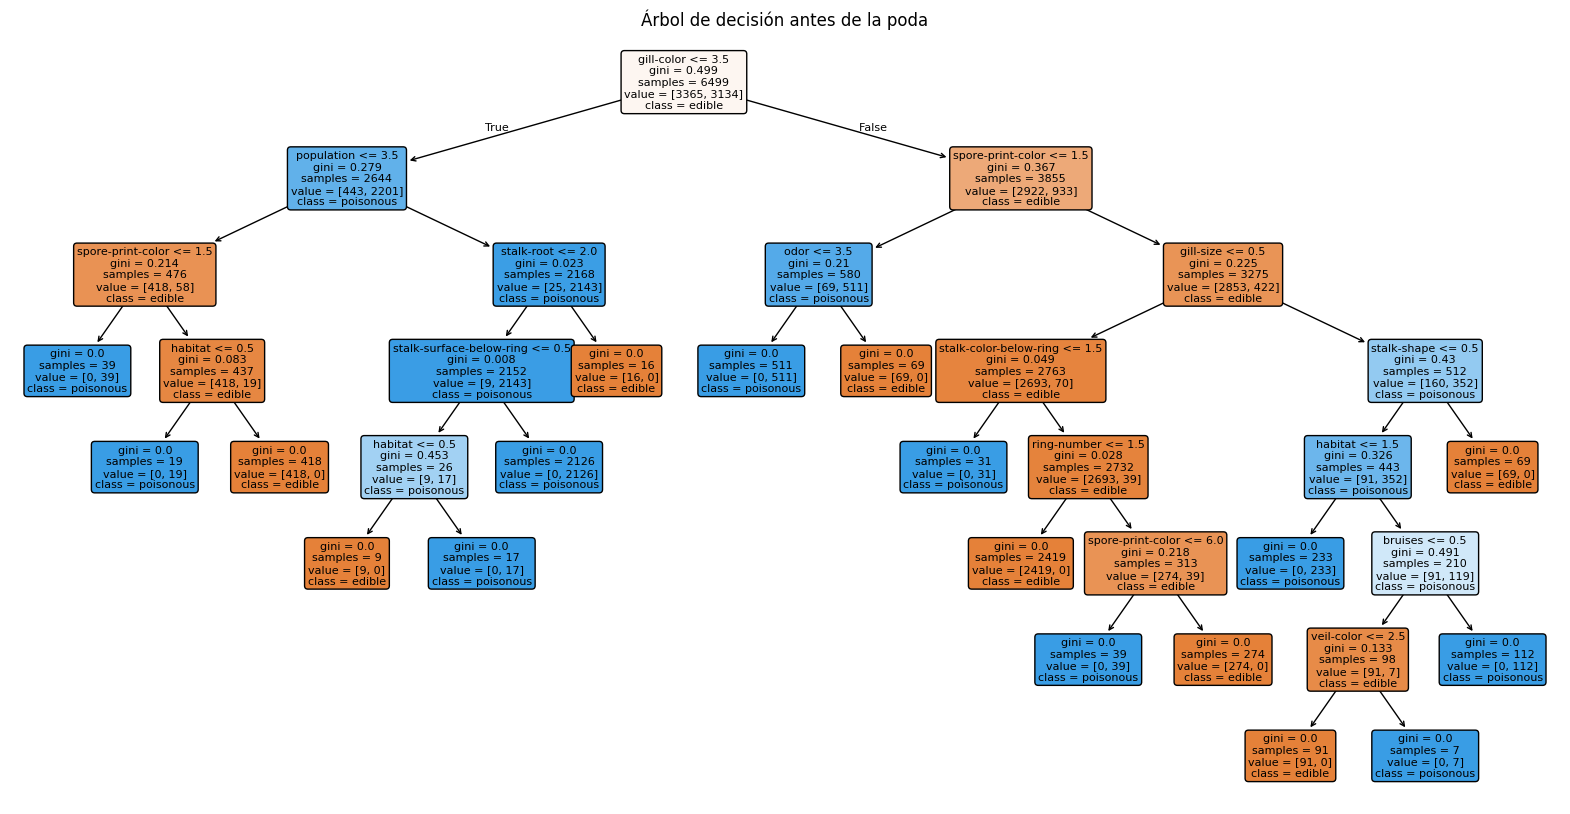

Modelo seleccionado con ccp_alpha=0.0101, precisión=0.9754, nodos=17


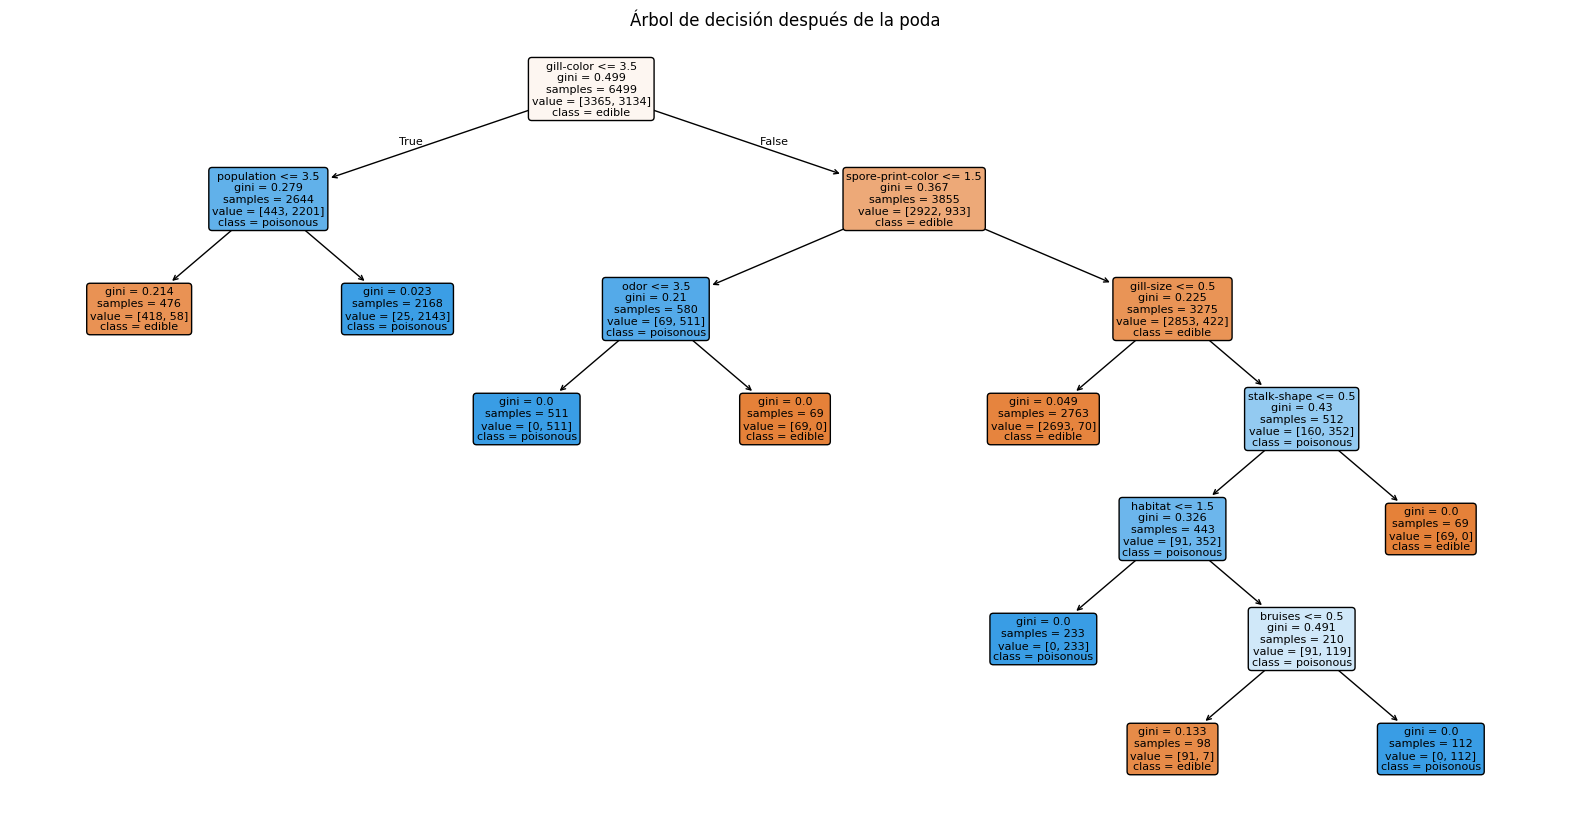

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type", "spore-print-color", "population", "habitat"]
data = pd.read_csv(url, names=columns)

# Codificar las variables categóricas a numéricas
label_encoders = {}
for column in data.columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Separar en variables predictoras y objetivo
X = data.drop(columns=["class"])
y = data["class"]

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de árbol de decisión con condición de parada
clf = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=10, min_samples_split=3)
clf.fit(X_train, y_train)

# Evaluar el modelo
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Precisión en entrenamiento: {train_accuracy:.2f}")
print(f"Precisión en validación: {test_accuracy:.2f}")

# Graficar el árbol de decisión antes de la poda
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["edible", "poisonous"], filled=True, rounded=True, fontsize=8)
plt.title("Árbol de decisión antes de la poda")
plt.show()

# Recorremos el árbol sin podar desde las hojas hasta la raíz, calculando los posibles valores de ccp_alpha.
path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas
# Excluir el primer alpha (ccp_alpha = 0) porque representa el árbol sin podar
alphas = alphas[1:]

# Generar y entrenar múltiples árboles podados para los diferentes valores de ccp_alpha
pruned_models = [DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(X_train, y_train) for alpha in alphas]

# Evaluar precisión y complejidad de cada árbol podado
test_accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in pruned_models]
num_nodes = [model.tree_.node_count for model in pruned_models]  # Número de nodos de cada árbol

# Encontrar el mejor compromiso entre precisión y simplicidad
# Estrategia: buscamos el árbol con el menor numero de nodos que aún mantiene al menos una precisión del 96%
precision_despues_de_poda=0.96
accuracy_threshold = max(test_accuracies) * precision_despues_de_poda
valid_indices = [i for i in range(len(pruned_models)) if test_accuracies[i] >= accuracy_threshold]

# Si hay modelos dentro del umbral de precisión, elegimos el más simple (menos nodos)
if valid_indices:
    # La función min() busca el índice de valid_indices que tiene el menor valor de num_nodes[i], 
    # es decir, el índice del árbol o modelo con el menor número de nodos.
    best_index = min(valid_indices, key=lambda i: num_nodes[i])
else:
    best_index = np.argmax(test_accuracies)  # En caso de que todos pierdan demasiada precisión

pruned_model = pruned_models[best_index]

print(f"Modelo seleccionado con ccp_alpha={alphas[best_index]:.4f}, precisión={test_accuracies[best_index]:.4f}, nodos={num_nodes[best_index]}")


# Graficar el árbol de decisión podado
plt.figure(figsize=(20, 10))
plot_tree(pruned_model, feature_names=X.columns, class_names=["edible", "poisonous"], filled=True, rounded=True, fontsize=8)
plt.title("Árbol de decisión después de la poda")
plt.show()


Ejercicio: Probar con distintos valores de precision para observar qu se generan diferentes arboles podados. ¿Que ocurre cuando el valor de precisión disminuye?

Ejercicio: ¿Que ocurre con los valores que representa un nodo al que se han podado una serie de nodos hijo cuando comparamos con el arbol no podado?